<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Keras_WithDeeplizard/blob/master/15_Train_A_Fine_Tuned_Neural_Network_With_TensorFlow's_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train A Fine-Tuned Neural Network With TensorFlow's Keras API
在本集中，我们将演示如何训练我们上次构建的经过微调的VGG16模型，以将图像分类为猫还是狗。

确保你已经准备好了我们在上一节中构建的模型的所有代码，因为我们将从那里直接开始。

此外，您还需要在前面的章节中组织和处理图像数据的代码。



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%tensorflow_version 2.x
print(tf.__version__)

2.4.0


In [ ]:
# 在colab上使用的云端数据
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats"

# 更改当前系统的路径
os.chdir(path)
# 显示当前路径的文件夹名字
print(os.listdir())

# 获得当前路径
os.getcwd()

['Dog', 'Cat', 'train', 'valid', 'test']


'/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats'

In [ ]:
os.chdir('..')
print(os.listdir())
train_path = './dogs-vs-cats/train'
valid_path = './dogs-vs-cats/valid'
test_path = './dogs-vs-cats/test'
num_steps = 100
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

['dogs-vs-cats']
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

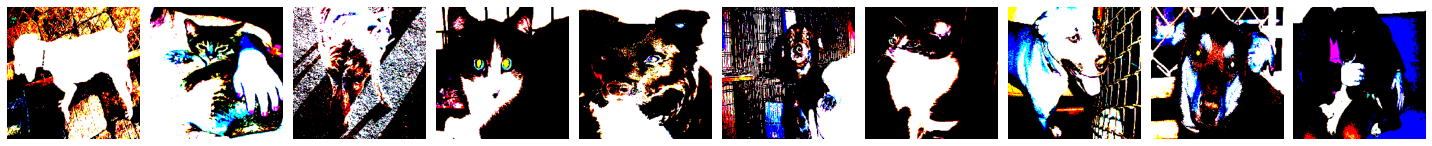

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 5s 0us/step


In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
for layer in model.layers:
  layer.trainable=False

In [ ]:
model.add(Dense(units=2,activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

使用我们的新模型，我们首先要做的是编译它。

与我们先前几集中的模型编译方法类似，我们将使用Adam优化器，其学习率为0.0001，categorical_crossentropy作为我们的损失，而“ accuracy”作为我们的指标。


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

现在，我们将使用model.fit（）训练模型。

In [ ]:
# model.fit(x=train_batches,
#           steps_per_epoch=len(train_batches),
#           validation_data=valid_batches,
#           validation_steps=len(valid_batches),
#           epochs=5,
#           verbose=2
# )
model.fit(x=train_batches,
          steps_per_epoch=20,
          validation_data=valid_batches,
          validation_steps=20,
          epochs=5,
          verbose=2
)

Epoch 1/5
20/20 - 202s - loss: 0.3136 - accuracy: 0.8750 - val_loss: 0.2114 - val_accuracy: 0.9150
Epoch 2/5
20/20 - 203s - loss: 0.2070 - accuracy: 0.9050 - val_loss: 0.1342 - val_accuracy: 0.9500
Epoch 3/5
20/20 - 199s - loss: 0.1673 - accuracy: 0.9100 - val_loss: 0.0998 - val_accuracy: 0.9600
Epoch 4/5


UnknownError: ignored

看看训练的结果，我们可以看到在5个时代之后，我们有一些非常出色的结果，特别是当你把它与我们从原始模型得到的结果比较时。

我们的准确率从88%开始，在短短5个时期内就超过99%。同样，我们的验证精度从95%提高到98%。

最显著的改进是，这个模型对验证数据的泛化非常好，不像我们以前从头构建的CNN。在下一集中，我们将使用这个新模型对测试集中的图像进行预测，并将结果与原始模型的预测进行比较。